In [1]:
import pandas as pd
import sqlite3
import os
import json
import sys
import numpy as np

import ast
import re

import math
from datetime import date

import pickle

import matplotlib.pyplot as plt
%matplotlib inline

# Stopwords

In [404]:
#stopwords list
from sklearn.feature_extraction import stop_words
stopwords = stop_words.ENGLISH_STOP_WORDS

#turn into a set then take the difference to pull out some words I don't want in list
stopwords = set(stopwords)
stopwords = stopwords.difference({'against', 'any','anything', 'because', 'bill','he','her','his','hers', 'him','she','i','mill','my','never','no','nobody','nothing','nowhere,','our','ours','mine','ourselves','out','take','together','us','we','why'})

In [405]:
# forms of the word you, which will be important in determining trolling behavior
you_forms = ['you','your','yours','yourself','yourselves']

# Gathering and Processing blocked users

In [1221]:
# Pull in blocklist users
conn = sqlite3.connect('tweets.db')
c = conn.cursor()
block_tweets_df = pd.read_sql_query("Select * from tweets",conn)
conn.close()

In [1222]:
block_tweets_df.shape

(3202354, 6)

In [5]:
# this should get rid of any duplicates (which I accidentally allowed in database)
conn = sqlite3.connect('tweets.db')
c = conn.cursor()
block_tweets_df = pd.read_sql_query("SELECT DISTINCT * from tweets",conn)
conn.close()

In [6]:
block_tweets_df.shape

(2248848, 6)

In [7]:
# pull off no mention tweets
block_nm_df = block_tweets_df[block_tweets_df['mentions']=="[]"]

In [8]:
# these are the troll candidates with mentions
block_twts_mentn_df = block_tweets_df[block_tweets_df['mentions'] != "[]"]

In [9]:
# this turns the mentions field into a list of screen_names
def clean_mentions(mentions):
    mention_list = re.sub(r'[^\x00-\x7f]',r'',str(mentions))
    mention_list = ast.literal_eval(mention_list)
    mention_screen_names = []
    for i in range(len(mention_list)):
        mention_screen_names.append(mention_list[i]['screen_name'])
    return mention_screen_names

In [ ]:
# get the mentions list clean on the whole dataframe
block_twts_mentn_df['cleanMentions'] = block_twts_mentn_df['mentions'].apply(clean_mentions)

# count up the mentions
block_twts_mentn_df['mention_count']=block_twts_mentn_df['cleanMentions'].apply(len)


In [15]:
# add in sentiment from Vader
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def sentiment(sentence):
    vs = analyzer.polarity_scores(sentence)
    return vs

/Users/angelavc/anaconda/envs/my_projects_env/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
# be sure the text of tweet is a string
block_twts_mentn_df['tweet'] = block_twts_mentn_df['tweet'].astype('str')

# then get the sentiment scores from Vader
block_twts_mentn_df['sentiment'] = block_twts_mentn_df['tweet'].apply(sentiment)

# Here we expand sentiment to 4 columns and then concatenate, deleting the original sentiment columns
block_twts_mentn_df = pd.concat([block_twts_mentn_df.drop(['sentiment'], axis=1), block_twts_mentn_df['sentiment'].apply(pd.Series)], axis=1)


In [ ]:
#length of the mention lists from 'cleanMentions'
lens = [len(list) for list in block_twts_mentn_df['cleanMentions']]

In [ ]:
# this is looking for "you language" in the tweets
block_twts_mentn_df['contains_you']=block_twts_mentn_df['tweet'].str.contains('|'.join(you_forms))

In [310]:
# how prevalent is you language in those on blocked list?
block_twts_mentn_df.contains_you.mean()

0.17657356646883063

In [46]:
# Get the screen name and target
block_twt_detail_df = pd.DataFrame( {"screen_name" : np.repeat(block_twts_mentn_df['screen_name'].values,lens), 
                                   "tweet" : np.repeat(block_twts_mentn_df['tweet'].values,lens),
                                   "tweet_id" : np.repeat(block_twts_mentn_df['tweet_id'].values,lens),
                                   "created_at" : np.repeat(block_twts_mentn_df['created_at'].values,lens),
                                   "troll" : np.repeat(block_twts_mentn_df['troll'].values,lens), 
                                   "compound":np.repeat(block_twts_mentn_df['compound'].values,lens), 
                                   'neg': np.repeat(block_twts_mentn_df['neg'].values,lens), 
                                   'neu': np.repeat(block_twts_mentn_df['neu'].values,lens),
                                   'pos': np.repeat(block_twts_mentn_df['pos'].values,lens),
                                   'contains_you': np.repeat(block_twts_mentn_df['contains_you'].values,lens),
                                   "target" : np.hstack(block_twts_mentn_df['cleanMentions'])
              })

In [47]:
# aggregation functions -- need count of tweets from screen_name to target and average sentiment
aggregations = {
    'screen_name':'count',
    'compound': 'mean',
    'neg': 'mean', 
    'neu': 'mean',
    'pos': 'mean',
    'contains_you': 'count',
    'tweet':'sum'
}

#group and aggregate
block_twt_detail_df = block_twt_detail_df.groupby(['screen_name','target']).agg(aggregations)

#fix all the names
oldnames = ['screen_name', 'compound', 'neg', 'neu', 'pos', 'countains_you','tweet']
newnames = ['target_count', 'compound', 'neg', 'neu', 'pos', 'contains_you','tweet']
block_twt_detail_df.rename(columns=dict(zip(oldnames, newnames)), inplace=True)

# reset the index to make it flat again
block_twt_detail_df = block_twt_detail_df.reset_index()

In [313]:
# this is just the list of blocklisted folks
trollist = block_twt_detail_df['screen_name'].unique()

In [314]:
len(trollist)

10302

# Trolling_df, defining what counts as trolling (you definition)

In [55]:
# to be trolling, must contain two @ mentions, be fairly negative (did <-.3 here) and contain a form of you

# further restrict to just tweets containing "you/your/etc"
block_twt_detail_df = block_twt_detail_df[block_twt_detail_df['tweet'].astype(str).str.contains('you')]

# here I reduced the number of targeted tweets to just two (b/c def more restricted)
trolling_df = block_twt_detail_df[(block_twt_detail_df['compound']<-.3) & (block_twt_detail2_df['target_count']>=2)].reset_index()

In [145]:
len(trolling_df['screen_name'].unique())

4266

In [148]:
# pull all the tweets for a user together into one string
block_tweets = trolling_df.groupby(['screen_name'])['tweet'].sum().reset_index()

In [149]:
# these are the trolls
block_tweets.shape

(4266, 2)

In [332]:
# list of who model things are trolls!
test_these

['007inVegas',
 '0173rivera',
 '0626833df75348c',
 '0aa',
 '0hmanitsang',
 '0nlyDTruth',
 '0olon_Colluph1d',
 '0ryuge',
 '0xMatt',
 '100million5',
 '11212121a',
 '11SBiase',
 '1418NOW',
 '14waffenwolf88',
 '16gbmicrosd',
 '1776Infowar',
 '17karmaistruth',
 '1991Lylka',
 '1AliceStern',
 '1Faith23',
 '1H4ND',
 '1TiredVeteran',
 '1USAalltheway',
 '1crocodile2',
 '1illuminatiGod',
 '1solidmf',
 '1stGenUSA',
 '21CenturyWN',
 '21foldmurdergod',
 '25_2_life_',
 '25thSec4_Action',
 '2ANow',
 '2ndAmendmnt',
 '2turntjauregui',
 '2tweetaboutit',
 '2wallyworld',
 '3headeddingo',
 '3ndscape',
 '3t3rn4l_j0y',
 '3tiltdat',
 '404errorist',
 '405Antifa',
 '420COAntiFa',
 '458african',
 '4NIKKOLAS',
 '4Rey_Bane',
 '4TrumpPence',
 '4afreeaustria',
 '4equalityMoore',
 '4everNeverTrump',
 '4happyfolks',
 '4n0nkid',
 '4nim4lF4rm',
 '4th_WaveNow',
 '50ShedsofGrey',
 '50xYomar',
 '5DAYSINDENVER',
 '601DvlDog',
 '602Erik',
 '614swat',
 '83TXOCHAIR',
 '85ceecee',
 '888Scott',
 '88heydrich',
 '88leooel',
 '8BitP

In [125]:
block_nm_twts = block_nm_df.groupby(['screen_name'])['tweet'].sum().reset_index()

# Gathering and Processing nonTrolling Tweets

In [67]:
# tweets2 has the non-blocklist user tweets
conn = sqlite3.connect('tweets2.db')
c = conn.cursor()
human_twts_df = pd.read_sql_query("Select * from tweets",conn)
conn.close()

In [326]:
human_twts_df.shape

(1973748, 6)

In [68]:
# pull off no mentions
human_nm_df = human_twts_df[human_twts_df['mentions']=="[]"]

# these are the ones with mentions
human_twts_ment_df = human_twts_df[human_twts_df['mentions'] != "[]"]

In [324]:
len(human_twts_df['screen_name'].unique())

10319

In [ ]:
# there is sometime bad string in mentions field, so pull it out
# then literal eval
human_twts_ment_df['cleanMentions'] = human_twts_ment_df['mentions'].apply(clean_mentions)

# count up the mentions
human_twts_ment_df['mention_count']=human_twts_ment_df['cleanMentions'].apply(len)


# be sure the text is a string
human_twts_ment_df['tweet'] = human_twts_ment_df['tweet'].astype('str')

# grab the sentiment fields
human_twts_ment_df['sentiment'] = human_twts_ment_df['tweet'].apply(sentiment)

# Here we expand sentiment to 4 columns and then concatenate, deleting the original sentiment columns
human_twts_ment_df = pd.concat([human_twts_ment_df.drop(['sentiment'], axis=1), human_twts_ment_df['sentiment'].apply(pd.Series)], axis=1)



In [77]:
human_twts_ment_df['contains_you']=human_twts_ment_df['tweet'].str.contains('|'.join(you_forms))

In [78]:
#length of the mention lists from 'cleanMentions'
lens = [len(list) for list 
        in human_twts_ment_df['cleanMentions']]


In [79]:
#
# Get the screen name and target
human_twt_detail_df = pd.DataFrame( {"screen_name" : np.repeat(human_twts_ment_df['screen_name'].values,lens), 
                                   "tweet" : np.repeat(human_twts_ment_df['tweet'].values,lens),
                                   "tweet_id" : np.repeat(human_twts_ment_df['tweet_id'].values,lens),
                                   "created_at" : np.repeat(human_twts_ment_df['created_at'].values,lens),
                                   "troll" : np.repeat(human_twts_ment_df['tweet_id'].values,lens),
                                   'mention_count':np.repeat(human_twts_ment_df['mention_count'].values,lens) ,
                                   'compound': np.repeat(human_twts_ment_df['compound'].values,lens),
                                   'neg': np.repeat(human_twts_ment_df['neg'].values,lens),
                                   'neu': np.repeat(human_twts_ment_df['neu'].values,lens),
                                   'pos': np.repeat(human_twts_ment_df['pos'].values,lens),
                                   'contains_you':np.repeat(human_twts_ment_df['contains_you'].values,lens),
                                   "target" : np.hstack(human_twts_ment_df['cleanMentions'])
              })

In [810]:
human_twt_detail_df.shape

(1913822, 11)

In [80]:
# aggregation functions -- need count of tweets from screen_name to target and average sentiment
aggregations = {
    'screen_name':'count',
    'compound': 'mean',
    'neg': 'mean', 
    'neu': 'mean',
    'pos': 'mean',
    'tweet':'sum',
    'contains_you':'count'
}

human_twt_detail_df = human_twt_detail_df.groupby(['screen_name','target']).agg(aggregations)

oldnames = ['screen_name', 'compound', 'neg', 'neu', 'pos','contains_you','tweet']
newnames = ['target_count', 'compound', 'neg', 'neu', 'pos', 'contains_you','tweet']

human_twt_detail_df.rename(columns=dict(zip(oldnames, newnames)), inplace=True)

human_twt_detail_df = human_twt_detail_df.reset_index()

In [81]:
human_twt_detail_df.shape

(916372, 7)

In [320]:
len(human_twt_detail_df['screen_name'].unique())

9592

In [83]:
# mark trolling behavior in human_twt_detail_df
human_twt_detail_df.ix[(human_twt_detail_df['compound'] <= -.5)&(human_twt_detail_df['target_count'] >= 2)&(human_twt_detail_df['contains_you']==True), 'trolling']=1

In [ ]:
# fixing and combining here!

In [87]:
human_twt_detail_df.head()

,screen_name,target,target_count,compound,neg,neu,pos,tweet,contains_you,trolling
0,000000000001110,333903271,1,0.000000,0.0000,1.00000,0.00000,"RT @333903271: #IvankaTrump defends dad, says ...",1,NaN
1,000000000001110,adao0o,8,0.014287,0.0365,0.92950,0.03400,RT @adao0o: Liberta - Peps | French Pop |30544...,8,NaN
2,000000000001110,alannalux,2,-0.051350,0.0520,0.94800,0.00000,RT @alannalux: University professor: Physics h...,2,NaN
3,000000000001110,amyrightside,4,-0.048800,0.0765,0.87375,0.04975,RT @amyrightside: Stars Cut it Out at Grammy A...,4,NaN
4,000000000001110,annjoyxc,1,0.000000,0.0000,1.00000,0.00000,RT @annjoyxc: SpeakUP - learn UK english and A...,1,NaN


In [88]:
human_twt_detail_df=human_twt_detail_df.fillna(False)

In [752]:
human_twt_detail_df['troll']=0

In [316]:
allNonBlocks = human_twt_detail_df['screen_name'].unique()

In [318]:
len(allNonBlocks)

9592

AttributeError: Unknown property colors

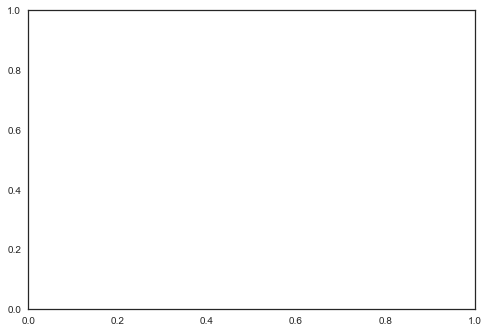

In [1006]:
g = sns.barplot(x="troll", y="target_count",data=target_summary,colors=['y','g'])
# remove the top and right line in graph
sns.despine()

# Set the size of the graph from here
g.figure.set_size_inches(12,8)
# Set the Title of the graph from here
g.axes.set_title('On Blocklist vs. Number of Mentions of Targets', fontsize=34,color="r",alpha=0.9)
# Set the xlabel of the graph from here
g.set_xlabel("On Blocklist",size = 34,color="r",alpha=0.9)
# Set the ylabel of the graph from here
g.set_ylabel("Mentions of Targets",size = 34,color="r",alpha=0.9)
# Set the ticklabel size and color of the graph from here
g.tick_params(labelsize=34,labelcolor="black")
g.set(xticklabels=['No',"Yes"])

In [ ]:
g = sns.barplot(x="troll", y="target_count",data=target_summary[target_summary])
# remove the top and right line in graph
sns.despine()

# Set the size of the graph from here
g.figure.set_size_inches(12,8)
# Set the Title of the graph from here
g.axes.set_title('On Blocklist vs. Number of Mentions of Targets', fontsize=34,color="r",alpha=0.5)
# Set the xlabel of the graph from here
g.set_xlabel("On Blocklist",size = 34,color="r",alpha=0.5)
# Set the ylabel of the graph from here
g.set_ylabel("Mentions of Targets",size = 34,color="r",alpha=0.5)
# Set the ticklabel size and color of the graph from here
g.tick_params(labelsize=14,labelcolor="black")
g.set(xticklabels=['No',"Yes"])

In [104]:
# aggregation functions -- need count of tweets from screen_name to target and average sentiment
aggregations2 = {
    'compound': 'mean',
    'neg': 'mean', 
    'neu': 'mean',
    'pos': 'mean',
    'tweet':'sum',
    'contains_you':'count'
}

In [105]:
notTrolls_df = human_twt_detail_df.groupby('screen_name').agg(aggregations2).reset_index()

In [151]:
len(human_twt_detail_df['screen_name'].unique())

9592

In [91]:
# note that in this whole collection there are only 293 cases of trolling
humanTrolls_df = notTrolls_df[notTrolls_df['trolling']>0]

In [150]:
notTrolls_df.shape

(9592, 8)

In [93]:
# just leave the non-trolling interactions
notTrolls_df = notTrolls_df[notTrolls_df['trolling']==0]

In [94]:
notTrolls_df.shape

(9592, 8)

In [132]:
# prepping the no mention tweets
human_nmTweets = human_nm_df.groupby(['screen_name'])['tweet'].sum().reset_index()

In [95]:
notTrolls_df.to_csv('nonTrollsJune21.csv',encoding='utf-8', header=True, index=False)

In [ ]:
# now pull the user information

In [96]:
humans1 = notTrolls_df['screen_name'].unique().tolist()

In [97]:
len(humans1)

9592

In [109]:
import random

shortHumans = random.sample(humans1, 4300)

In [ ]:
shortHumans

In [818]:
human1_users=[]
# now getting all of the user info
# try loop is needed mostly in case users have been suspended
for i in range(len(shortHumans)):
    print('Getting {x}'.format(x=shortHumans[i]))
    
    try:
        human1_users.append(api.get_user(screen_name = shortHumans[i]))
    except tweepy.TweepError as e:
        print('Error ')
        print(e.api_code)
        pass


Getting qweenchi
Getting junlhoe
Getting battleborns
Getting saltyshima
Getting strateia
Getting laurengebbiia
Getting Ina_Magalhaes
Getting FenneyJoseph
Getting cayliglowka
Getting Detroit_BRocka
Getting amaliaSyakirah
Getting Waifudere
Getting FuckFrenche
Getting ZachMorrison2Go
Getting zzdynty
Getting charliedingwall
Getting gracespacinixx
Getting ali_zulhairie
Getting bastbast1909
Getting NlGGANO
Getting Lustydivass
Getting QwertyPoppp
Getting elf_emoz
Getting boothang_siple
Getting Cruz1119
Getting anneisntdead
Getting DanWantsToTravl
Getting StockfishJason
Getting lyeaaa_
Getting thewealthie
Getting sjcrazykawaii
Getting 1000Discohits
Getting TheSunCameOut
Getting LlaqatNazran
Getting its3ajme7
Getting nourshabo_
Getting luckycornerviet
Getting katie_ionescu
Getting ontimatic
Getting jmlg05
Getting kwonelitist
Getting sndramendezz
Getting FusedonHolloway
Getting Damisa__Sarki
Getting jhoana_dennis
Getting theshadowlady
Getting khusta_ndlovumk
Getting MuffinMendes89
Getting lynell

In [827]:
len(human1_users)

892

In [349]:
human1_df = pd.DataFrame(human1_users,columns=['user'])

In [273]:
def accountAge(timestamp):
    calc = date.today() - timestamp.date()
    return calc.days

In [453]:
# get all descriptions
human1_df['description'] = human1_df['user'].apply(lambda x: x.description)
human1_df['statuses_count'] =  human1_df['user'].apply(lambda x: x.statuses_count)
human1_df['screen_name'] =  human1_df['user'].apply(lambda x: x.screen_name)

human1_df['followers_count'] =  human1_df['user'].apply(lambda x: x.followers_count)
human1_df['friends_count'] =  human1_df['user'].apply(lambda x: x.friends_count)
human1_df['favourites_count'] =  human1_df['user'].apply(lambda x: x.favourites_count)
human1_df['listed_count'] =  human1_df['user'].apply(lambda x: x.listed_count)
human1_df['location'] =  human1_df['user'].apply(lambda x: x.location)
human1_df['created_at'] =  human1_df['user'].apply(lambda x: x.created_at)
human1_df['accountAge'] = human1_df['created_at'].apply(accountAge)
human1_df['time_zone'] =  human1_df['user'].apply(lambda x: x.time_zone)
human1_df['name'] =  human1_df['user'].apply(lambda x: x.name)

In [458]:
human_twts = human_nm_df.groupby(['screen_name'])['tweet'].sum().reset_index()

In [460]:
human1_df = pd.merge(human1_df, human_twts, on='screen_name')

In [454]:
human1_df.shape

(444, 19)

In [278]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def sentiment(sentence):
    vs = analyzer.polarity_scores(sentence)
    return vs

In [352]:
# be sure description is a string!
human1_df['description'] = human1_df['description'].astype('str')

In [353]:
human1_df['sentiment'] = [None if d == None else sentiment(d) for d in human1_df['description']]

In [354]:
human1_df = pd.concat([human1_df, human1_df['sentiment'].apply(pd.Series)], axis=1)

In [355]:
human1_df.shape

(444, 17)

In [374]:
human1_df.columns.values

array(['user', 'description', 'statuses_count', 'followers_count',
       'friends_count', 'favourites_count', 'listed_count', 'location',
       'created_at', 'accountAge', 'time_zone', 'name', 'sentiment',
       'compound', 'neg', 'neu', 'pos', 'troll'], dtype=object)

# Prepping for Modeling

In [152]:
notTrolls_df.shape

(9592, 8)

In [153]:
block_tweets.shape

(4266, 2)

In [166]:
notTrolls_df['troll']=0

In [167]:
block_tweets['troll']=1

In [ ]:
# now have to take the users in these two dataframes and return the tweets without mentions

In [174]:
troll1 = block_nm_twts.set_index('screen_name').index
troll2 = block_tweets.set_index('screen_name').index
trolls_df = block_nm_twts[troll1.isin(troll2)]
trolls_df['troll']=1

/Users/angelavc/anaconda/envs/my_projects_env/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [175]:
human1 = human_nmTweets.set_index('screen_name').index
human2 = notTrolls_df.set_index('screen_name').index
humans_df = human_nmTweets[human1.isin(human2)]
humans_df['troll']=0

/Users/angelavc/anaconda/envs/my_projects_env/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [176]:
humans_df=humans_df.sample(4050)

In [253]:
#now combine the two
users_df = humans_df.append(trolls_df)

In [178]:
users_df.shape

(8098, 3)

In [179]:
users_df = users_df.reset_index()

In [255]:
users_df.head()

,screen_name,tweet,troll
2863,NadaBeloued,#4YEARSWITHBTS thank you for always being ther...,0
6950,katieagnew_,#NewProfilePic don't know where I would be wi...,0
8312,rodneyd44,I just checked in at 24 Hour Fitness with #mPL...,0
4564,_datzhurrrrrr,✌✌✌✌✌✌✌✌✌✌ get excited about paying shit offT...,0
4826,amaan_vally,Just because you don't fit your own standard o...,0


In [254]:
# replace all urls with an empty string
users_df['tweet'] = users_df['tweet'].apply(lambda x: re.sub(r"http\S+", "", x))

In [1223]:
# output dataset I used for original analysis
users_df.to_csv('users_df_June20.csv',encoding='utf-8', header=True, index=False)

In [182]:
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer

In [183]:
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

/Users/angelavc/anaconda/envs/my_projects_env/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [271]:
# split users into test and train

X_train, X_test, y_train, y_test = train_test_split(users_df, users_df['troll'],test_size=0.3, random_state=21)


In [185]:
# cleanup tweet text
def clean_tweet(tweet):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

In [186]:
# First do some preprocessing using above function, eg.
clean_tweet(users_df['tweet'].iloc[374])

'RT gambler panty maid stocking bonus christmas panty parellel world fallen angel and Chocolate in one scoop Yes please AlproIceCream Flippers Space Trucker wait for Splatoon 2 I m loving the Nintendo Switch so far there s still so much stuff I wanna get for it RT gambler panty maid stocking bonus christmas panty parellel world fallen angel and Chocolate in one scoop Yes please AlproIceCream Flippers Space Trucker wait for Splatoon 2 I m loving the Nintendo Switch so far there s still so much stuff I wanna get for it'

In [256]:
# implement on all the rows
users_df['tweet'] = users_df['tweet'].apply(clean_tweet)

In [257]:
users_df['tweet'] = users_df['tweet'].str.lower()

# Model: Logistic Regression on User Features

In [574]:
processed_df = pd.DataFrame(preprocessing.scale(users_df[['favourites_count', 'followers_count',
       'listed_count', 'accountAge', 'friends_count', 'statuses_count',
       'compound','proba_troll','troll']]), columns = ['favourites_count', 'followers_count',
       'listed_count', 'accountAge', 'friends_count', 'statuses_count',
       'compound','proba_troll','troll'])

In [1156]:
processed_df.head()

,favourites_count,followers_count,listed_count,accountAge,friends_count,statuses_count,compound,proba_troll,troll
0,-0.338646,-0.058700,-0.130241,0.226147,-0.181849,-0.343597,-0.314447,-0.603062,1.0
1,-0.231706,-0.057616,-0.102409,-1.293827,-0.083737,-0.246192,0.405395,1.306509,1.0
2,-0.441440,-0.054911,-0.075787,0.139661,0.046201,-0.365362,-1.320435,0.411398,1.0
3,-0.373459,-0.042270,-0.049165,1.530403,-0.179871,-0.175318,-1.335454,0.232375,1.0
4,-0.456734,-0.060681,-0.124190,-0.822625,-0.258031,-0.219886,-0.314447,1.545205,1.0


In [365]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [373]:
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

/Users/angelavc/anaconda/envs/my_projects_env/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [585]:
y, X = dmatrices('troll ~ favourites_count + followers_count + listed_count + accountAge + friends_count +\
                  statuses_count + compound + proba_troll',processed_df, return_type="dataframe")

In [586]:
# flatten y into 1-D
y = np.ravel(y)

In [587]:
# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
model3 = LogisticRegression()
model3.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [588]:
# predict class labels for the test set
predicted = model3.predict(X_test)

In [589]:
# generate class probabilities
probs = model3.predict_proba(X_test)

In [590]:
# generate evaluation metrics
print(metrics.accuracy_score(y_test, predicted))
print(metrics.roc_auc_score(y_test, probs[:, 1]))

0.740890688259
0.791486291486


In [591]:
# look at the model
# examine the coefficients
dict(zip(X.columns.values.T, np.ravel(model3.coef_.T)))

{'Intercept': -0.012849482167810984,
 'accountAge': 0.11860937918407662,
 'compound': -0.046373583211742279,
 'favourites_count': 0.013537796011101904,
 'followers_count': -8.1701830791855445e-05,
 'friends_count': -0.3624522127076989,
 'listed_count': 0.14081901145683404,
 'proba_troll': 1.3966299255493115,
 'statuses_count': -0.42128821807425915}

In [582]:
print(metrics.classification_report(y_test, predicted))

             precision    recall  f1-score   support

       -1.0       0.58      0.38      0.46       126
        1.0       0.52      0.71      0.60       121

avg / total       0.55      0.54      0.53       247



# Model: Support Vector Classifier
    
    

In [192]:
from sklearn.svm import SVC

In [190]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer


In [307]:
vectorizer =TfidfVectorizer( max_features = 5000, ngram_range=(1,2), stop_words=you_forms )


# fit_transform() fits the model & and learns the vocab (features)
# then it transforms the training data into feature vectors. 
# The input to fit_transform should be a list of 
# strings.
X_train_vectorized = vectorizer.fit_transform(X_train['tweet'])

# convert to array
X_train_vectorized = X_train_vectorized.toarray()

svm = SVC(C=1, gamma="auto", kernel='rbf')
svm = svm.fit( X_train_vectorized, y_train )



In [308]:
result = svm.predict(X_test_vectorized)

In [309]:
print(classification_report(y_test,result))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1247
          1       0.49      1.00      0.65      1183

avg / total       0.24      0.49      0.32      2430



/Users/angelavc/anaconda/envs/my_projects_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Model: Logistic Regression on Bag of Words

In [ ]:
# mostly got this from http://streamhacker.com/2010/05/24/text-classification-sentiment-analysis-stopwords-collocations/

In [352]:
def words(text_block):
    return re.sub("[^\w]", " ",  text_block).split()

def word_feats(words):
    return dict([(word, True) for word in words])

In [376]:
def merge_dicts(dict1,dict2):
    result = {}
    result.update(dict1)
    result.update(dict2)
    return result

In [388]:
import collections
import nltk.classify.util, nltk.metrics


 


X_troll = X_train[X_train['troll']==1]
X_human = X_train[X_train['troll']==0]

def evaluate_classifier(featx,X_troll,X_human):
    tr_feats = X_troll.tweet.apply(words).apply(featx)
    hu_feats = X_human.tweet.apply(words).apply(featx)
 
    negcutoff = int(math.ceil(len(hu_feats)*3/4))
    poscutoff = int(math.ceil(len(tr_feats)*3/4))
    
    trainfeats = merge_dicts(hu_feats[:negcutoff],tr_feats[:poscutoff])
    testfeats = merge_dicts(hu_feats[negcutoff:],tr_feats[poscutoff:])
 
    classifier = LogisticRegression().fit(trainfeats,y_train)
    refsets = collections.defaultdict(set)
    testsets = collections.defaultdict(set)
 
    for i, (feats, label) in enumerate(testfeats):
            refsets[label].add(i)
            observed = classifier.classify(feats)
            testsets[observed].add(i)
 
    print('accuracy: '+nltk.classify.util.accuracy(classifier, testfeats))
    print('pos precision: '+nltk.metrics.precision(refsets['pos'], testsets['pos']))
    print( 'pos recall:' + nltk.metrics.recall(refsets['pos'], testsets['pos']))
    print ('neg precision:'+ nltk.metrics.precision(refsets['neg'], testsets['neg']))
    print ('neg recall:'+ nltk.metrics.recall(refsets['neg'], testsets['neg']))
    classifier.show_most_informative_features()

In [353]:
word_feats(['asdfasdf','asfasdf','asdf'])

{'asdf': True, 'asdfasdf': True, 'asfasdf': True}

In [336]:
import itertools
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
 
def bigram_word_feats(words, score_fn=BigramAssocMeasures.chi_sq, n=200):
    bigram_finder = BigramCollocationFinder.from_words(words)
    bigrams = bigram_finder.nbest(score_fn, n)
    return dict([(ngram, True) for ngram in itertools.chain(words, bigrams)])
 



In [ ]:
from nltk.corpus import stopwords
stopset = set(stopwords.words('english'))
 
def stopword_filtered_word_feats(words):
    return dict([(word, True) for word in words if word not in stopset])
 
evaluate_classifier(stopword_filtered_word_feats)

In [337]:
evaluate_classifier(bigram_word_feats)

NameError: name 'evaluate_classifier' is not defined

In [474]:
vectorizer = TfidfVectorizer( max_features = 10000, ngram_range=(1,2), stop_words=stopwords, sublinear_tf=True )
X_train_vectorized = vectorizer.fit_transform(X_train['tweet']).toarray()

In [475]:
LR = LogisticRegression().fit(X_train_vectorized, y_train )


In [476]:
X_test_vectorized = vectorizer.transform(X_test['tweet']).toarray()

In [477]:
# predict class labels for the test set
predicted = LR.predict(X_test_vectorized)

In [282]:
probs = LR.predict_proba(X_test_vectorized)

In [478]:
# generate evaluation metrics
print(metrics.accuracy_score(y_test, predicted))
print(metrics.roc_auc_score(y_test, probs[:, 1]))

0.79012345679
0.849196482378


In [334]:
from sklearn.metrics import confusion_matrix


In [479]:
confusion_matrix(y_test, predicted)

array([[1018,  229],
       [ 281,  902]])

In [480]:
print(metrics.classification_report(y_test, predicted))

             precision    recall  f1-score   support

          0       0.78      0.82      0.80      1247
          1       0.80      0.76      0.78      1183

avg / total       0.79      0.79      0.79      2430



In [447]:
# vocab = feature names
vocab = vectorizer.get_feature_names()

In [449]:

 
imp_df = pd.DataFrame({'features':vocab,'coeff':LR.coef_.flatten()}).sort_values('coeff')

In [327]:
with open('LR_model.pkl', 'wb') as fout:
  pickle.dump((vectorizer, LR), fout)

In [432]:
stopwords = list(stopwords)

In [428]:
'of' in stopwords

True

In [455]:
imp_df[imp_df['coeff']>1.3]

,coeff,features
4815,1.301189,we
1583,1.305700,fathers
4741,1.318977,violence
216,1.322189,america
1156,1.323449,democrats
2499,1.330879,left
2932,1.341103,muslims
2265,1.349357,islam
1743,1.351207,fuck
221,1.361833,americans


In [461]:
imp_df[imp_df['coeff']<-1.05]

,coeff,features
2662,-2.530111,love
2936,-2.107242,my
3583,-2.059536,que
618,-1.739444,bts
3072,-1.669188,night
4289,-1.645718,summer
30,-1.591494,2017
176,-1.441788,ain
3064,-1.386238,ni
3166,-1.376591,onelovemanchester


In [227]:
from sklearn.metrics import roc_curve

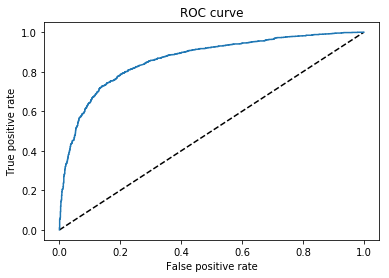

In [482]:
# The LR model by itself
y_pred_lr = LR.predict_proba(X_test_vectorized)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr_lr, tpr_lr,)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [472]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.
    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt







<module 'matplotlib.pyplot' from '/Users/angelavc/anaconda/envs/my_projects_env/lib/python3.6/site-packages/matplotlib/pyplot.py'>

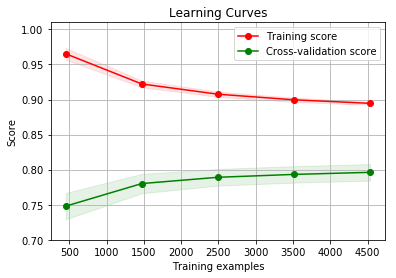

In [481]:
title = "Learning Curves"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = LogisticRegression()
plot_learning_curve(estimator, title, X_train_vectorized, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

# Model: Random Forest

In [234]:
from sklearn.ensemble import RandomForestClassifier


In [258]:
# This is to include other features with the sparse word features
X_train_vectorized = sp.sparse.hstack((vectorizer.fit_transform(X_train['tweet']),X_train[['friends_count','statuses_count']].values),format='csr')
X_columns=vectorizer.get_feature_names()+X_train[['friends_count','statuses_count']].columns.tolist()

# do same for test
X_test_vectorized = sp.sparse.hstack((vectorizer.transform(X_test['tweet']),X_test[['friends_count','statuses_count']].values),format='csr')


NameError: name 'sp' is not defined

In [259]:
# Initialize TFIDF vectorizor object (no n-grams)
vectorizer = TfidfVectorizer( max_features = 10000, ngram_range=(1,2),sublinear_tf = True,stop_words=you_forms )
#vectorizer = CountVectorizer( max_features = 5000, ngram_range=(1,2) )




In [289]:
# fit_transform() fits the model & and learns the vocab (features)
# then it transforms the training data into feature vectors. 
# The input to fit_transform should be a list of 
# strings.
X_train_vectorized = vectorizer.fit_transform(X_train['tweet'])

# convert to array
X_train_vectorized = X_train_vectorized.toarray()


In [290]:
# Initialize a Random Forest classifier with 100 trees
# oob_score gives "out of bag" errors
forest = RandomForestClassifier(n_estimators = 100,oob_score=True) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run


forest = forest.fit( X_train_vectorized, y_train )


In [291]:
X_test_vectorized = vectorizer.transform(X_test['tweet']).toarray()

In [292]:
# vocab = feature names
vocab = vectorizer.get_feature_names()

In [293]:
# get counts of all words
vocabCounts = pd.DataFrame(np.column_stack([vocab, np.asarray(X_train_vectorized.sum(axis=0).ravel())]), 
                               columns=['vocab', 'count'])

In [295]:
# how does the train set do on the out of bag reviews?
forest.oob_score_

0.75317572335920957

In [239]:
scores = cross_val_score(forest,X_train_vectorized, y_train, cv=5)
print(scores)                                              

[ 0.78306878  0.78218695  0.77160494  0.7749338   0.76169462]


In [506]:
# Get predictors for this random forest from cross-validation
from sklearn.model_selection import cross_val_predict

In [922]:
predTroll = cross_val_predict(forest,X_train_vectorized, y_train, cv=5)

In [265]:
result = forest.predict(X_test_vectorized)

In [242]:
# model evaluation
from sklearn.metrics import classification_report

In [296]:
print(classification_report(y_test,result))

             precision    recall  f1-score   support

          0       0.78      0.79      0.79      1247
          1       0.78      0.76      0.77      1183

avg / total       0.78      0.78      0.78      2430



In [930]:
predicted = cross_val_predict(forest,X_train_vectorized, y_train, cv=5,method='predict_proba')

In [931]:
predictedRF = predicted

In [298]:
importances = forest.feature_importances_

In [300]:
imp_df = pd.DataFrame({'features':vocab,'import':importances}).sort_values('import')

In [1081]:
from sklearn.metrics import roc_curve

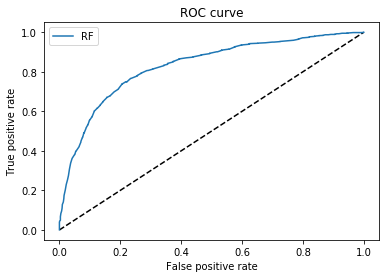

In [297]:
# The random forest model by itself
y_pred_rf = forest.predict_proba(X_test_vectorized)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [301]:
imp_df[["features","import"]].sort_values(by="import")

,features,import
1636,gemini may,0.000000
2496,lmao lmao,0.000000
3517,righ,0.000000
2576,maga usa,0.000000
3518,righ more,0.000000
2483,little inclin,0.000000
2957,now playing,0.000000
3343,project at,0.000000
2777,mplusplaces download,0.000000
2673,means different,0.000000


In [1220]:
imp_df[imp_df['columns']=="you"]

KeyError: 'columns'

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)


In [608]:
# add this as feature to users_df
users_df['proba_nonTroll']=predicted[:,0].tolist()

In [609]:
users_df['proba_troll']=predicted[:,1].tolist()

In [621]:
users_df[.head()]

,user,description,statuses_count,followers_count,friends_count,favourites_count,listed_count,location,created_at,accountAge,...,neu,pos,troll,screen_name,tweet,probaRF,proba_nonTroll,proba_troll,X_new_preds,predTroll
374,User(_api=<tweepy.api.API object at 0x2fe3b219...,-Photoholic❤DegreeHolder❤Dancer❤Singer(sa bany...,-0.343597,-0.058700,-0.181849,-0.338646,-0.130241,"Tiaong, Calabarzon",2012-10-31 09:33:39,0.226147,...,1.000,0.000,1,siiPeRlita,one person followed me // automatically checke...,"[0.62, 0.38]",0.54,0.46,1,0
86,User(_api=<tweepy.api.API object at 0x2fe3b219...,"Semi-retired Chef and Baker, US Navy Veteran U...",-0.246192,-0.057616,-0.083737,-0.231706,-0.102409,Shasta County California,2017-01-07 04:30:49,-1.293827,...,0.905,0.095,1,JefferyHankins2,FUCKING #BUILDTHATWALL! HOLY COW! https://t.co...,"[0.3, 0.7]",0.32,0.68,1,1
175,User(_api=<tweepy.api.API object at 0x2fe3b219...,Indie game dev working on Mammoth Gravity Batt...,-0.365362,-0.054911,0.046201,-0.441440,-0.075787,"Cambridge, uk",2013-01-26 14:42:01,0.139661,...,0.843,0.000,1,SpaceMammoth,Space Mammoths are dancing in support of world...,"[0.45, 0.55]",0.52,0.48,1,1
43,User(_api=<tweepy.api.API object at 0x2fe3b219...,Progressive Political Commentator & Syndicated...,-0.175318,-0.042270,-0.179871,-0.373459,-0.049165,"Long Island, New York",2009-03-29 05:22:16,1.530403,...,0.820,0.000,1,ChristopherHahn,Happy 😊🐞https://t.co/PdINtPZ0ckStating the obv...,"[0.48, 0.52]",0.55,0.45,1,1
110,User(_api=<tweepy.api.API object at 0x2fe3b219...,born U.S.A.,-0.219886,-0.060681,-0.258031,-0.456734,-0.124190,BRONX N.Y.,2015-09-21 00:07:02,-0.822625,...,1.000,0.000,1,MYTQIN,WHAT S NEEDED NOW IS DID J. COMEY LEAK THE MEE...,"[0.26, 0.74]",0.22,0.78,1,1


In [615]:
new_samples = users_df['tweet']

In [1079]:
with open('forest_model.pkl', 'wb') as fout:
  pickle.dump((vectorizer, forest), fout)

In [1064]:
with open('forest_model.pkl', 'rb') as fin:
    vectorizer, forest = pickle.load(fin)

X_new = vectorizer.transform(new_samples)
X_new_preds = forest.predict(X_new)

In [617]:
users_df['X_new_preds']=X_new_preds

In [722]:
tweetsText = string.join(tweets)

NameError: name 'string' is not defined

In [712]:
tweetsTest = pd.DataFrame(tweets,columns=['tweets'])

In [719]:
tweetsText = tweetsTest['tweets'].sum()

In [720]:
vectorizer.transform([tweetsText])

<1x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 449 stored elements in Compressed Sparse Row format>

In [665]:
twts = api.user_timeline(screen_name = 'faroop', count = 50, include_rts = True, tweet_mode = "extended")

In [666]:
tweets = [[tweet.full_text] for tweet in twts]

In [668]:
tweetsText = ''

In [671]:
for tweet in tweets:
    tweetsText += ' ' + tweet[0]

In [688]:
vectorizer.transform(tweets)

AttributeError: 'list' object has no attribute 'lower'

In [658]:
json.dumps(twts)

TypeError: Object of type 'Status' is not JSON serializable

In [643]:
tweets = []
for tweet in twts:
    tweets.append(tweet._json)

In [646]:
tweetText=''
for tweet in tweets:
    tweetText += tweet.text

AttributeError: 'dict' object has no attribute 'text'

In [654]:
tweets[0]

{'contributors': None,
 'coordinates': None,
 'created_at': 'Wed Jun 07 13:46:56 +0000 2017',
 'entities': {'hashtags': [],
  'symbols': [],
  'urls': [{'display_url': 'twitter.com/AcademiaObscur…',
    'expanded_url': 'https://twitter.com/AcademiaObscura/status/872449396788666368',
    'indices': [110, 133],
    'url': 'https://t.co/c5kRYadFt4'}],
  'user_mentions': [{'id': 580240697,
    'id_str': '580240697',
    'indices': [16, 31],
    'name': 'Insight Data Science',
    'screen_name': 'InsightDataSci'}]},
 'favorite_count': 0,
 'favorited': False,
 'geo': None,
 'id': 872449799236321280,
 'id_str': '872449799236321280',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': True,
 'lang': 'en',
 'place': None,
 'possibly_sensitive': False,
 'quoted_status': {'contributors': None,
  'coordinates': None,
  'created_at': 'Wed Jun 07 13:45:20 +0000 2017',

In [1065]:
X_new_preds

array([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 0,

# Model: SVM with RF results

In [542]:
y, X = dmatrices('troll ~ favourites_count + followers_count + listed_count + accountAge + friends_count +\
                  statuses_count + compound + proba_troll',users_df, return_type="dataframe")

In [543]:
# flatten y into 1-D
y = np.ravel(y)

In [544]:
from sklearn.utils import shuffle

# make sure they are mixed up
users_df = shuffle(users_df)


In [ ]:
# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
model4 = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)


In [546]:
# predict class labels for the test set
predicted = model4.predict(X_test)

In [547]:
# generate class probabilities
probs = model4.predict_proba(X_test)

In [548]:
# generate evaluation metrics
print(metrics.accuracy_score(y_test, predicted))
print(metrics.roc_auc_score(y_test, probs[:, 1]))

0.542510121457
0.554178145087


In [549]:
print(metrics.classification_report(y_test, predicted))

             precision    recall  f1-score   support

        0.0       0.55      0.40      0.46       121
        1.0       0.54      0.68      0.60       126

avg / total       0.54      0.54      0.53       247



In [ ]:
# But interestingly, it is not really better?? Actually is worse!

In [ ]:
# More random forest below

In [491]:

# Initialize TFIDF vectorizor object (no n-grams)
vectorizer = TfidfVectorizer( max_features = 10000, ngram_range=(1,2),sublinear_tf = True )

# fit_transform() fits the model & and learns the vocab (features)
# then it transforms the training data into feature vectors. 
# The input to fit_transform should be a list of 
# strings.
X_train_vectorized = vectorizer.fit_transform(X_train['tweet'])

# convert to array
X_train_vectorized = X_train_vectorized.toarray()

scaler = preprocessing.StandardScaler().fit(X_train_vectorized)
X_train_transformed = scaler.transform(X_train_vectorized)

# Initialize a Random Forest classifier with 100 trees
# oob_score gives "out of bag" errors
forest = RandomForestClassifier(n_estimators = 100,oob_score=True) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run

forest = forest.fit( X_train_transformed, y_train )


In [493]:
# Get a bag of words for the test set, and convert to a numpy array, this time just with transform (no fit)
X_test_vectorized = vectorizer.transform(X_test['tweet'])

# convert to array
X_test_vectorized = X_test_vectorized.toarray()

scaler = preprocessing.StandardScaler().fit(X_test_vectorized)
X_test_transformed = scaler.transform(X_test_vectorized)


In [494]:
forest.score(X_test_transformed, y_test)     

0.48987854251012147

# SVM

In [473]:
from sklearn.model_selection import train_test_split

from sklearn import svm

In [474]:
clf = svm.SVC(kernel='linear', C=1).fit(train_data_features, y_train)
clf.score(train_data_features, y_test)                           


ValueError: Found input variables with inconsistent numbers of samples: [247, 416]

# Naive Bayes

In [413]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer

def split_into_lemmas(tweet):
    bigram_vectorizer = CountVectorizer(ngram_range=(1, 3), token_pattern=r'\b\w+\b', min_df=1)
    analyze = bigram_vectorizer.build_analyzer()
    return analyze(tweet)




In [414]:
bow_transformer = CountVectorizer(analyzer = split_into_lemmas, stop_words='english', strip_accents='ascii').fit(users_df['description'])

text_bow = bow_transformer.transform(users_df['description'])
tfidf_transformer = TfidfTransformer().fit(text_bow)
tfidf = tfidf_transformer.transform(text_bow)

text_tfidf = tfidf_transformer.transform(text_bow)

In [415]:
classifier_nb = MultinomialNB(class_prior=[0.5, 0.5]).fit(text_tfidf, users_df['troll'])